In this notebook, I'm going to do some experimentation with xgboost on only the real clinical data

In [1]:
!pip install xlrd

    100% |████████████████████████████████| 112kB 3.9MB/s 
menpo 0.8.1 has requirement matplotlib<2.0,>=1.4, but you'll have matplotlib 3.0.2 which is incompatible.
menpo 0.8.1 has requirement pillow<5.0,>=3.0, but you'll have pillow 5.4.0 which is incompatible.
menpo 0.8.1 has requirement scipy<1.0,>=0.16, but you'll have scipy 1.2.0 which is incompatible.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import sklearn.metrics

In [3]:
import os
import re
from collections import Counter
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
os.getcwd()

'/floyd/home/notebooks'

In [5]:
path = '/floyd/home/notebooks'
data_path = '/floyd/home/data'

In [6]:
clin = pd.read_excel(data_path + '/jj_modified_bch_data.xlsx')

In [8]:
len(clin)

136993

In [9]:
clin.columns

Index(['ID', 'ChartNumber', 'EncounterNumber', 'TriageLevel', 'AgeNumber',
       'AgeInYrs', 'GenderDesc', 'Triage Date & Time', 'Reg Date & Time',
       'PIA Date & Time', 'Disposition Date & Time', 'DischargeDisposition',
       'DischargeDispositionDesc', 'Left ED Date & Time',
       'PresentingComplaint', 'PresentingComplaintDesc', 'MainDiagnosisCode',
       'MainDiagnosisCodeDesc', 'AdmitLocation', 'PatientService',
       'SubjectiveNotes', 'InfectionControlScreening', 'MedicalHistory',
       'BloodPressure_LastEDReading', 'O2Saturation_LastEDReading',
       'Pulse_LastEDReading', 'Temperature_LastEDReading',
       'Are you feeling feverish or have had shakes or chills in the last 24 hours?',
       'Have you ever been isolated/required isolation for an infectious disease when receiving care in a healthcare setting?',
       'Do you have a new Rash?',
       'Do you have a new onset of Vomiting/Diarrhea in the last 24 hours?',
       'Have you travelled outside of Canada/U

In [10]:
comp_count = Counter(clin['PresentingComplaint']); comp_count

Counter({852: 6203,
         401: 870,
         253: 418,
         409: 801,
         3: 9095,
         653: 2650,
         855: 970,
         151: 589,
         555: 4332,
         251: 13156,
         556: 4613,
         102: 561,
         407: 3371,
         7: 3008,
         651: 5830,
         352: 1419,
         410: 692,
         657: 1674,
         51: 930,
         101: 540,
         704: 2587,
         257: 3521,
         351: 2630,
         104: 1376,
         304: 180,
         999: 3855,
         256: 266,
         554: 2568,
         8: 1871,
         861: 1023,
         103: 859,
         866: 698,
         506: 347,
         457: 1323,
         557: 4802,
         403: 1914,
         5: 1591,
         4: 2279,
         853: 343,
         301: 2131,
         751: 1473,
         710: 858,
         258: 431,
         713: 176,
         551: 4129,
         859: 1820,
         804: 224,
         10: 348,
         404: 3481,
         260: 857,
         254: 819,
         306:

In [11]:
o2sat = [item if item[-1] != '%' else item[:-1] for item in clin['O2Saturation_LastEDReading'].astype('str')]
o2sat = [np.nan if item == 'nan' else float(item) for item in o2sat] 
clin['o2sat'] = o2sat

In [12]:
pulse = clin['Pulse_LastEDReading']
pulse = [re.sub("[^0-9]", "", str(item)) for item in pulse]
pulse = [np.nan if item == '' else float(item) for item in pulse] 
#set(pulse)
clin['pulse'] = pulse

In [13]:
temp = clin['Temperature_LastEDReading']
temp = [re.sub("[^0-9]", "", str(item)) for item in temp]
temp = [np.nan if item == '' else float(item) for item in temp] 
temp = [item/10 if item > 100 else item for item in temp]
temp = [np.nan if item > 40  else item for item in temp]
#set(temp)
clin['temp'] = temp

**bptrans** parses the blood pressure column into systolic and diastolic, **fixencode** does some preprocessing on text 

In [14]:
def bptrans(bp):
    if pd.isnull(bp):
        return [np.nan, np.nan]
    res = []
    for x in bp.split('/'):
        try:
            float(x)
            res =  [float(x) for x in bp.split('/')]
        except: 
            res =  [np.nan, np.nan]
        return res

def fixencode(s):
    if pd.isnull(s):
        s = "None"
    s=s.replace('<LT><LF>',',')
    s=s.replace('Pt.', 'patient')
    s=s.replace('Pt', 'patient')
    s= s.replace('pt.', 'patient')
    s=s.replace('pt', 'patient')
    s = s.replace('y/o', 'year old')
    s = s.replace('c/o', 'complains of')
    s = s.replace('C/o', 'complains of')
    return s

In [15]:
clin['BP'] = clin.BloodPressure_LastEDReading.map(bptrans)
clin[['systolic', 'diastolic']] = pd.DataFrame(clin.BP.tolist(), index= clin.index)
clin["Gender"] = clin.GenderDesc.map(lambda x: 1 if x == "Male" else 0)

In [16]:
admit_count= Counter(clin['AdmitLocation']); admit_count

Counter({nan: 120106,
         'N.SUR GEN': 1024,
         'N.MED CARD': 1738,
         'N.ER IN': 1186,
         'N.MED SIX': 604,
         'N.CC ICU': 455,
         'N.CC CCU': 584,
         'N.MED ONC': 1024,
         'N.MAU': 2365,
         'N.SIMCU': 301,
         'N.MED CPU': 329,
         'N.MED GER': 1070,
         'N.MED CT': 144,
         'N.WC PAED': 1291,
         'N.ERMH IN': 29,
         'N.MED SIM': 450,
         'N.SUR ORTH': 661,
         'N.MH CHADI': 152,
         'N.MH GER': 68,
         'N.MH GENB': 217,
         'N.MH INTEN': 234,
         'N.MED RESP': 944,
         'N.MED NEUR': 921,
         'N.SUR SS': 582,
         'N.MH CHAD': 210,
         'N.WC POST': 119,
         'N.MH GENC': 47,
         'N.MED DIAL': 48,
         'N.CC NICU': 5,
         'N.WC LD': 2,
         'N.WC LDN': 1,
         'N.MAIN OR': 1,
         'N.MED STTU': 1,
         'N.MED FLEX': 10,
         'N.MED DSU': 69,
         'N.SUR DSU': 1})

In [22]:
clin['outcome'] = clin['AdmitLocation'].astype('str').map(
{'N.CC CCU': 'ICU',
 'N.CC ICU': 'ICU',
 'N.ER IN' : 'madmit',
 'N.ERMH IN': 'madmit',
 'N.MAU': 'madmit',
 'N.MED CARD': 'madmit',
 'N.MED CPU': 'madmit',
 'N.MED CT': 'madmit',
 'N.MED GER': 'madmit',
 'N.MED DIAL': 'madmit',
 'N.MED NEUR': 'madmit',
 'N.MED ONC': 'madmit',
 'N.MED RESP': 'madmit',
 'N.MED SIM': 'madmit',
 'N.MED SIX': 'madmit',
 'N.MH CHAD': 'madmit',
 'N.MH CHADI': 'madmit',
 'N.MH GENB': 'madmit',
 'N.MH GER': 'madmit',
 'N.MH INTEN': 'madmit',
 'N.SIMCU': 'ICU',
 'N.SUR GEN': 'sadmit',
 'N.SUR ORTH': 'sadmit',
 'N.SUR SS': 'sadmit',
 'N.WC PAED': 'madmit',
 'N.WC POST': 'madmit',
 'N.MH GENC': 'madmit',
 'N.CC NICU': 'ICU',
 'N.WC LD': 'sadmit',
  'N.WC LDN': 'sadmit',
  'N.MAIN OR': 'sadmit',
  'N.MED STTU': 'madmit',
  'N.MED FLEX': 'madmit',
    'N.MED DSU': 'madmit',
    'N.SUR DSU': 'sadmit',
 'nan': 'discharge'})

In [23]:
clin['target'] = clin['outcome'].map({'discharge': 1, 'madmit': 2, 'sadmit': 3, 'ICU': 4})

In [24]:
outcome_count = Counter(clin['outcome']); outcome_count

Counter({'discharge': 120106, 'sadmit': 2272, 'madmit': 13270, 'ICU': 1345})

In [25]:
target_count = Counter(clin['target']); target_count

Counter({1: 120106, 3: 2272, 2: 13270, 4: 1345})

In [26]:
out_dict = {'discharge': 1, 'madmit': 2, 'sadmit': 3, 'ICU': 4}
out_dict = {v:k for k,v in out_dict.items()}
out_dict

{1: 'discharge', 2: 'madmit', 3: 'sadmit', 4: 'ICU'}

In [27]:
o2sat = [item if item[-1] != '%' else item[:-1] for item in clin['O2Saturation_LastEDReading'].astype('str')]
o2sat = [np.nan if item == 'nan' else float(item) for item in o2sat] 
clin['o2sat'] = o2sat

In [28]:
pulse = clin['Pulse_LastEDReading']
pulse = [re.sub("[^0-9]", "", str(item)) for item in pulse]
pulse = [np.nan if item == '' else float(item) for item in pulse] 
#set(pulse)
clin['pulse'] = pulse

In [29]:
temp = clin['Temperature_LastEDReading']
temp = [re.sub("[^0-9]", "", str(item)) for item in temp]
temp = [np.nan if item == '' else float(item) for item in temp] 
temp = [item/10 if item > 100 else item for item in temp]
temp = [np.nan if item > 40  else item for item in temp]
#set(temp)
clin['temp'] = temp

In [30]:
clin['discharge'] = clin['outcome'].map({'discharge': 1, 'madmit': 0, 'sadmit': 0, 'ICU': 0})

In [31]:
clin['dispo']= clin['outcome'].map({'discharge': np.nan, 'madmit': 1, 'sadmit': 2, 'ICU': 3})

Now we are going to split stuff up into features and train some models

In [32]:
features = clin[['systolic', 'diastolic', 'pulse', 'o2sat', 'temp', 'AgeInYrs', 'Gender']]
features2 = clin[['systolic', 'diastolic', 'pulse', 'o2sat', 'temp', 'AgeInYrs', 'Gender', 'PresentingComplaint']]

In [33]:
target2 = clin['discharge']
target1 = clin['target']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(features, target1) #, random_state=1)
xgc = xgb.XGBClassifier()
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
conf = confusion_matrix(y_test, preds); conf

test set outcome counts:  1    30004
2     3335
3      560
4      350
Name: target, dtype: int64


array([[29780,   223,     0,     1],
       [ 2971,   362,     0,     2],
       [  532,    28,     0,     0],
       [  311,    39,     0,     0]])

In [36]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
prec = sklearn.metrics.precision_score(y_test,preds, average = None)
rec = sklearn.metrics.recall_score(y_test,preds, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

weighted f1:  0.8381141744403392
f1:           [0.93650744 0.18159017 0.         0.        ]
accuracy:     0.8800840900464247
precision:    [0.88646782 0.55521472 0.         0.        ]
recall:       [0.99253433 0.10854573 0.         0.        ]


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
target_dict = {'discharge': 1, 'madmit': 2, 'sadmit': 3, 'ICU': 4}

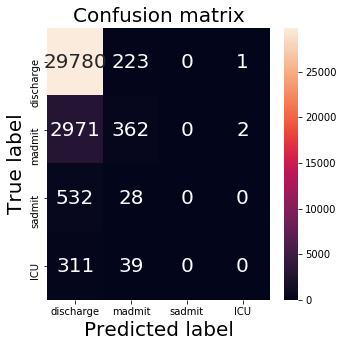

In [38]:
LABELS = target_dict.keys()  #['admit', 'discharge'] #lab_count.keys()

plt.figure(figsize=(5, 5))
sns.heatmap(conf, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

So, now we are going to try the same but adding in presenting complaint

In [39]:
X_train, X_test, y_train, y_test = train_test_split(features2, target1) #, random_state=1)
xgc = xgb.XGBClassifier()
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
conf = confusion_matrix(y_test, preds); conf

array([[29849,   263,     0,     0],
       [ 2633,   582,     0,     1],
       [  515,    68,     0,     0],
       [  277,    60,     0,     1]])

In [40]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
prec = sklearn.metrics.precision_score(y_test,preds, average = None)
rec = sklearn.metrics.recall_score(y_test,preds, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

weighted f1:  0.8542032689913721
f1:           [0.9418168  0.27787061 0.         0.00588235]
accuracy:     0.8885514905544687
precision:    [0.89706678 0.59815005 0.         0.5       ]
recall:       [0.99126594 0.18097015 0.         0.00295858]


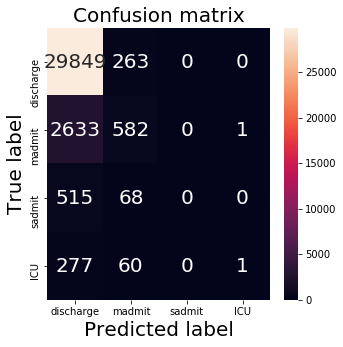

In [41]:
LABELS = target_dict.keys()  #['admit', 'discharge'] #lab_count.keys()

plt.figure(figsize=(5, 5))
sns.heatmap(conf, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [42]:
#check for overfitting
preds = xgc.predict(X_train)
conf = confusion_matrix(y_train, preds); conf

array([[89233,   757,     0,     4],
       [ 8150,  1903,     0,     1],
       [ 1543,   146,     0,     0],
       [  788,   216,     0,     3]])

In [43]:
#so we are underfitting.  gonna train more (I think)
xgc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [45]:
preds = xgc.predict(X_test)
conf = confusion_matrix(y_test, preds); conf

array([[29849,   263,     0,     0],
       [ 2633,   582,     0,     1],
       [  515,    68,     0,     0],
       [  277,    60,     0,     1]])

In [46]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
prec = sklearn.metrics.precision_score(y_test,preds, average = None)
rec = sklearn.metrics.recall_score(y_test,preds, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

weighted f1:  0.8542032689913721
f1:           [0.9418168  0.27787061 0.         0.00588235]
accuracy:     0.8885514905544687
precision:    [0.89706678 0.59815005 0.         0.5       ]
recall:       [0.99126594 0.18097015 0.         0.00295858]


In [47]:
#check for overfitting
preds = xgc.predict(X_train)
conf = confusion_matrix(y_train, preds); conf

array([[89233,   757,     0,     4],
       [ 8150,  1903,     0,     1],
       [ 1543,   146,     0,     0],
       [  788,   216,     0,     3]])

In [48]:
X_train, X_test, y_train, y_test = train_test_split(features2, target2) #, random_state=1)
xgc = xgb.XGBClassifier()
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
conf = confusion_matrix(y_test, preds); conf

array([[  873,  3407],
       [  380, 29589]])

In [51]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
prec = sklearn.metrics.precision_score(y_test,preds)#, average = None)
rec = sklearn.metrics.recall_score(y_test,preds)#, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

weighted f1:  0.8618391947698452
f1:           [0.31556118 0.93985548]
accuracy:     0.8894274285380595
precision:    0.8967450600072736
recall:       0.9873202309052688


In [53]:
adult = clin[clin['AgeInYrs'].astype(int) > 16]

In [54]:
len(adult)

113858

In [65]:
features = adult[['systolic', 'diastolic', 'pulse', 'o2sat', 'temp', 'AgeInYrs', 'Gender']]
features2 = adult[['systolic', 'diastolic', 'pulse', 'o2sat', 'temp', 'AgeInYrs', 'Gender'
                   , 'PresentingComplaint']]

In [66]:
target2 = adult['discharge']
target1 = adult['target']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(features2, target1) #, random_state=1)
xgc = xgb.XGBClassifier()
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
conf = confusion_matrix(y_test, preds); conf

array([[24388,   259,     0,     1],
       [ 2314,   592,     0,     0],
       [  526,    51,     0,     0],
       [  275,    57,     0,     2]])

In [68]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
prec = sklearn.metrics.precision_score(y_test,preds, average = None)
rec = sklearn.metrics.recall_score(y_test,preds, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

weighted f1:  0.8412811286258783
f1:           [0.93528408 0.30633894 0.         0.01186944]
accuracy:     0.8776392060425083
precision:    [0.88673963 0.6173097  0.         0.66666667]
recall:       [0.98945148 0.20371645 0.         0.00598802]


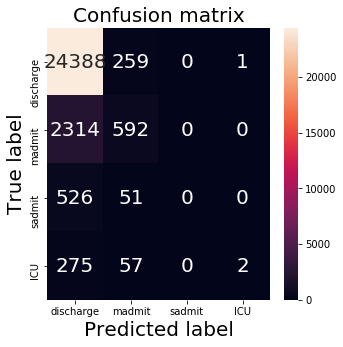

In [69]:
LABELS = target_dict.keys()  #['admit', 'discharge'] #lab_count.keys()

plt.figure(figsize=(5, 5))
sns.heatmap(conf, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [82]:
X_train, X_test, y_train, y_test = train_test_split(features2, target1) #, random_state=1)
xgc = xgb.XGBClassifier(objective='multi:softmax', max_depth = 7, min_child_weight = 0.5, reg_lambda = 0.5)
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
conf = confusion_matrix(y_test, preds); conf

array([[24203,   387,    14,     5],
       [ 2154,   780,     7,    19],
       [  473,    68,    10,     0],
       [  246,    87,     0,    12]])

In [83]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
prec = sklearn.metrics.precision_score(y_test,preds, average = None)
rec = sklearn.metrics.recall_score(y_test,preds, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

weighted f1:  0.8490004319399239
f1:           [0.936558   0.36431574 0.03436426 0.06299213]
accuracy:     0.8784472158791499
precision:    [0.89389127 0.59001513 0.32258065 0.33333333]
recall:       [0.98350197 0.26351351 0.01814882 0.03478261]


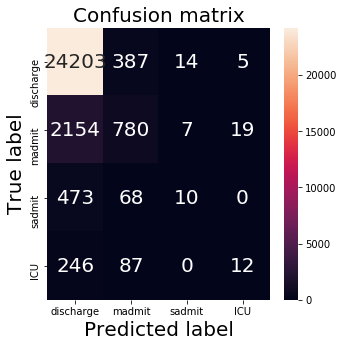

In [84]:
LABELS = target_dict.keys()  #['admit', 'discharge'] #lab_count.keys()

plt.figure(figsize=(5, 5))
sns.heatmap(conf, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

What follows is going to be some work on hyperparameter selection and tuning as the model is underfitting

In [74]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate, GridSearchCV   #Additional scklearn functions
#from sklearn.grid_search import GridSearchCV 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


In [ ]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')